In [111]:
import obspy
from obspy.io.sac.sactrace import SACTrace
from obspy.io.sac.util import get_sac_reftime
from obspy.signal.cross_correlation import correlate, xcorr_max, xcorr_pick_correction
import os
import glob
import numpy
import matplotlib.pyplot as plt

In [112]:
def do_alignP(data_dir, time_before, time_after, appendix):
    """
    align data according to the theoretical arrival time of P (the phase has been written in sacheader)
    """
    if not os.path.exists(data_dir):
        print("Missing File: %s" % data_dir)

    for ev in os.listdir(data_dir):
        inpath = os.path.join(data_dir, ev)
        
        for bp in glob.glob(f"{inpath}/*.{appendix}"):
            # align waveform according to P
            sac = SACTrace.read(bp)
            sac._allt(-1*sac.t1)
            sac.write(bp, headonly=True)
            # cut the waveform within a given time window
            tr = obspy.read(bp)
            T = get_sac_reftime(tr[0].stats.sac) + tr[0].stats.sac.t1
            tr.trim(starttime = T-time_before, endtime = T+time_after, fill_value=0)
            tr[0].write(bp +".cut", format='SAC')

In [113]:
def do_ccmeasure(data_dir, coe_thesh, window_left, window_right, Tshift, appendix):
    """
    calculate cc of each two traces within the folder, and only output the measurements above coe_thresh
    """
    
    def _cal_Ncorr_(npts, data1, data2):
        sum = 0
        sum1 = 0
        sum2 = 0
        for i in range(0, npts, 1):
            sum  += (data1[i] * data2[i])
            sum1 += (data1[i] * data1[i])
            sum2 += (data2[i] * data2[i])
        return(sum/numpy.sqrt(sum1*sum2))
    
    
    if not os.path.exists(data_dir):
        print("Missing File: %s" % data_dir)

    for ev in os.listdir(data_dir):
        inpath = os.path.join(data_dir, ev)
        f = open(f"{inpath}/ccmeasure.info", "w")
        
        st = obspy.read(f"{inpath}/*.{appendix}")
        
        for i in range(0, st.count(), 1):
            if(i+1<st.count()):
                T1r = get_sac_reftime(st[i].stats.sac)
                NM1 = "".join(str(T1r).split("T")[0].split("-")) + "".join("".join("".join(str(T1r).split("T")[1].split("Z")).split(".")).split(":"))
                for j in range(i+1, st.count(), 1):
                    T2r = get_sac_reftime(st[j].stats.sac)
                    NM2 = "".join(str(T2r).split("T")[0].split("-")) + "".join("".join("".join(str(T2r).split("T")[1].split("Z")).split(".")).split(":"))
               #     print("*******  evt1: {}  evt2: {}  **********".format(NM1,NM2))
           #######################################################################
                    bN = int(numpy.rint((window_left - st[i].stats.sac.b) / st[i].stats.sac.delta))
                    if(bN < 0):
                        bN = 0
                    eN = int(numpy.rint((window_right - st[i].stats.sac.b) / st[i].stats.sac.delta))
                    if(eN > st[i].stats.sac.npts):
                        eN = st[i].stats.sac.npts
                    npts = eN - bN + 1
                    TN = int(numpy.rint(Tshift / st[j].stats.sac.delta))
                    if(st[i].stats.sac.delta != st[j].stats.sac.delta):
                        print("Inconsistent sampling rate of file1 and file2: check sacFiles' sampling rate")
                        break
                    if(st[i].stats.sac.b > window_left or st[j].stats.sac.b > window_left-Tshift or st[i].stats.sac.e < window_right or st[j].stats.sac.e < window_right+Tshift):
                        print("Window out of the data, check that")
                        break
                    if(npts <= 1):
                        print("No points for f1: check time window or sacFile")
                        break
                        
                    NCC =[]
                    TCCshift = []
                    for k in range(-1*TN, TN, 1):
                        NCC.append(_cal_Ncorr_(npts,st[i].data[bN:bN+npts],st[j].data[bN+k:bN+k+npts]))
                        TCCshift.append(k*st[j].stats.sac.delta)
                    
                    max_index = numpy.argmax(NCC)
                 #   print("Shift: {:6.4f}  NCoe: {:5.3f}  evt1: {}  evt2: {}".format(TCCshift[max_index], NCC[max_index], NM1, NM2))
                    f.write("Shift: {:6.4f}  NCoe: {:5.3f}  evt1: {}  evt2: {}\n".format(TCCshift[max_index], NCC[max_index], NM1, NM2))
                    
                    if(NCC[max_index]>0.7):
                        print("Shift: {:6.4f}  NCoe: {:5.3f}  evt1: {}  evt2: {}".format(TCCshift[max_index], NCC[max_index], NM1, NM2))
                        # Quick waveform check
                        st1 = st[i]
                        st2 = st[j]

                        d1 = st1.data
                        d1 -= d1[0]

                        d2 = st2.data
                        d2 -= d2[0]

                        t = np.arange(-1*Tcut1, st1.stats.npts / st1.stats.sampling_rate-1*Tcut1, st1.stats.delta)
                        t2 = np.arange(-1*Tcut1, st2.stats.npts / st2.stats.sampling_rate-1*Tcut1, st2.stats.delta)
                        t3 = np.arange(-1*Tcut1+TCCshift[max_index], st2.stats.npts / st2.stats.sampling_rate-1*Tcut1+TCCshift[max_index], st2.stats.delta)

                        plt.figure(figsize=(26,4))
                        plt.plot(t,d1/max(d1),label="ST1", color="blue", linewidth=0.3)
                        plt.plot(t2,d2/max(d2),label="ST2", color="green")
                        plt.plot(t3,d1/max(d1),label="Shifted ST1", color="red")
                      #  plt.xlim(-1*window_left, window_left)
                        plt.legend()
                        plt.title('Waveform Showing', fontsize=20)
                        plt.grid()

                        plt.show()
                      #  os.sys.exit()
        f.close()

Shift: -0.7000  NCoe: 0.765  evt1: 20200626185507950000  evt2: 20200713011828080000


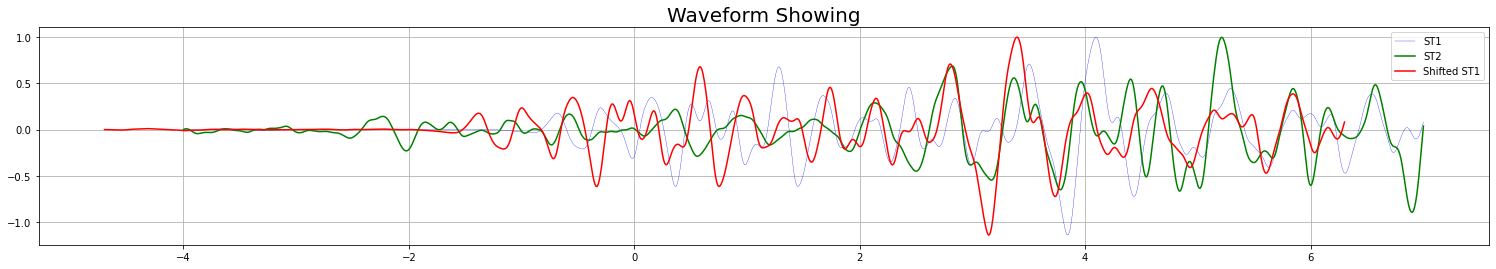

Shift: -0.4500  NCoe: 0.716  evt1: 20200626185507950000  evt2: 20200730032301850000


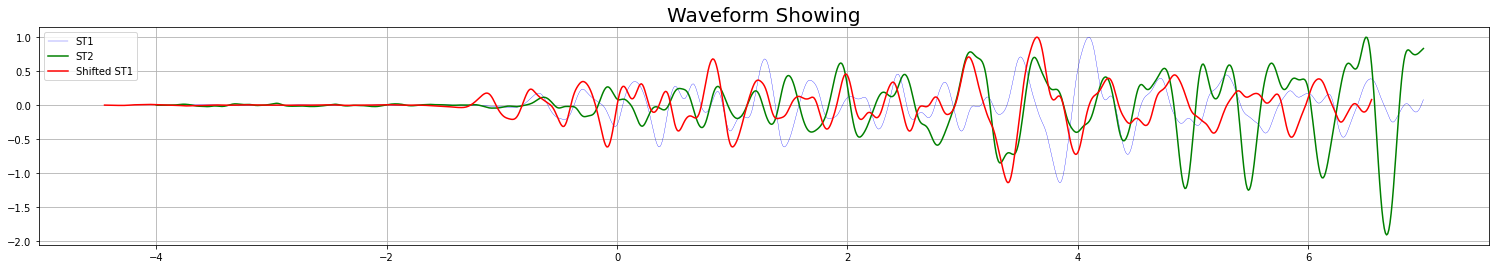

Shift: 0.3000  NCoe: 0.756  evt1: 20200626185507950000  evt2: 20201204031825150000


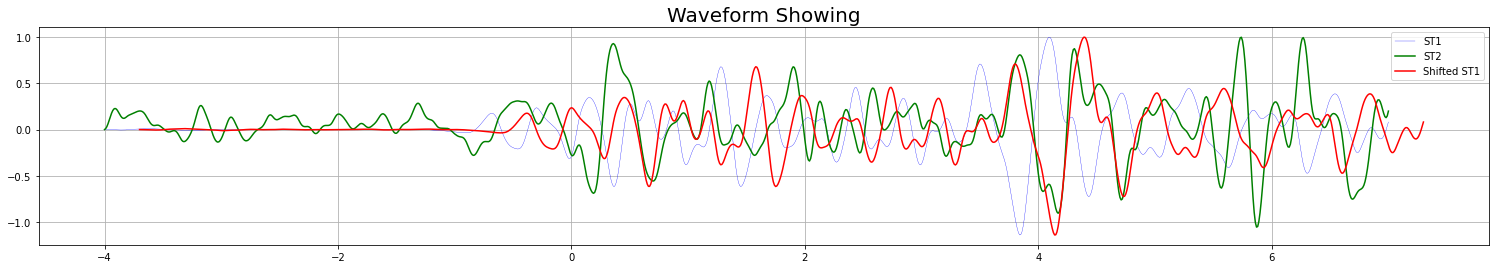

Shift: -0.0600  NCoe: 0.886  evt1: 20200730112928990000  evt2: 20200730134819160000


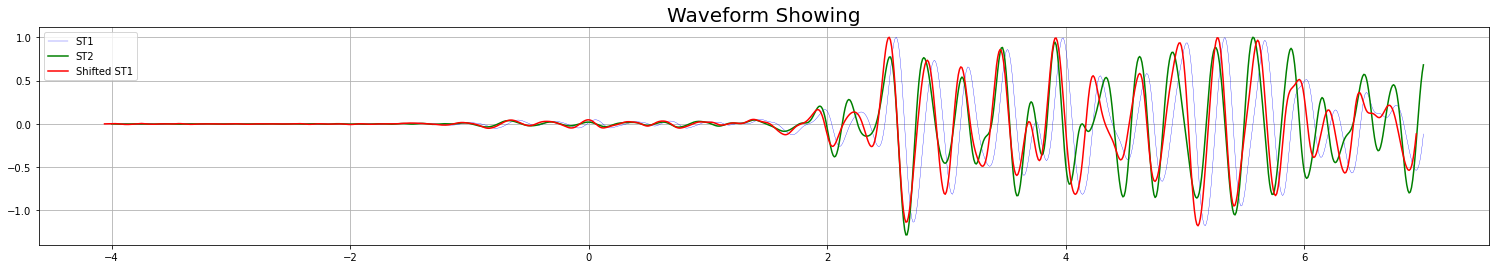

Shift: -0.2900  NCoe: 0.776  evt1: 20200730112928990000  evt2: 20201022061014890000


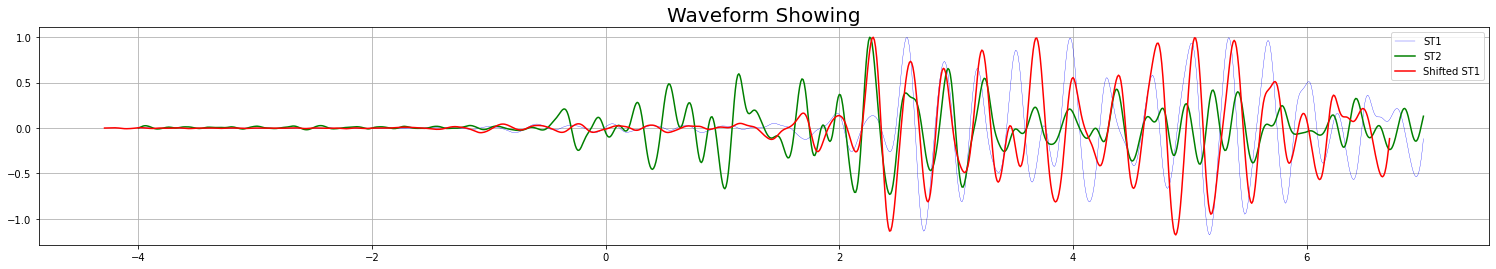

Shift: -0.2300  NCoe: 0.704  evt1: 20200730134819160000  evt2: 20201022061014890000


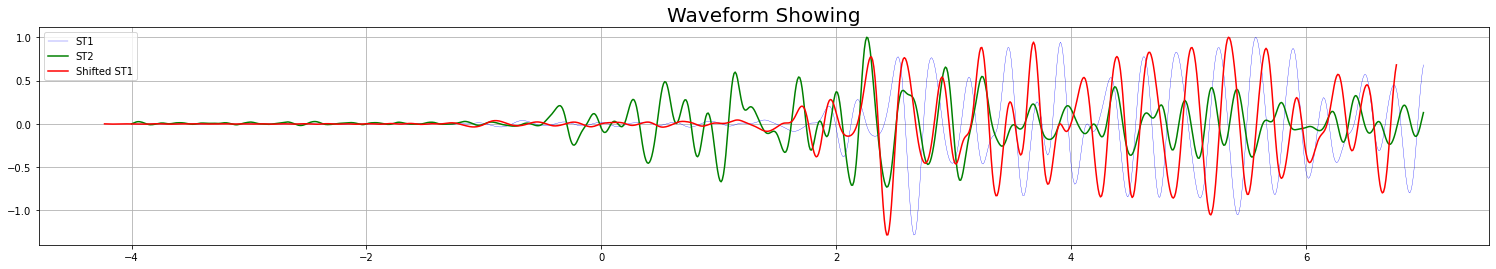

Shift: -0.9200  NCoe: 0.701  evt1: 20200906014836730000  evt2: 20200919063846860000


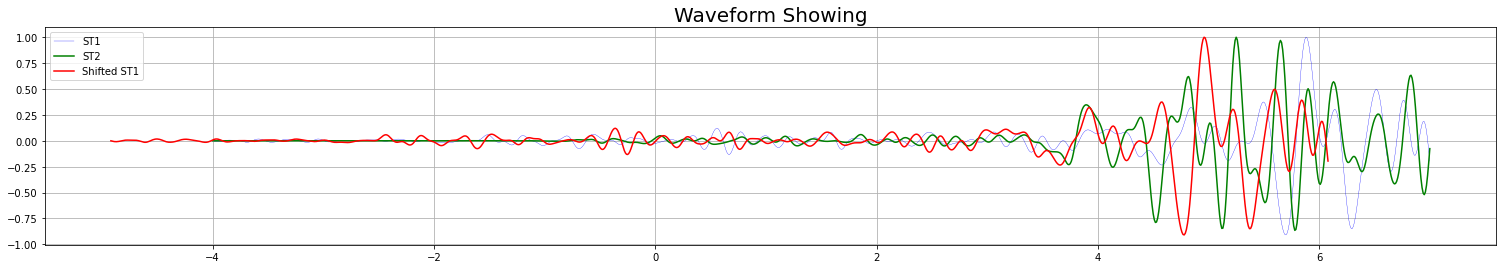

Shift: -0.9300  NCoe: 0.733  evt1: 20200929022220750000  evt2: 20201027192243900000


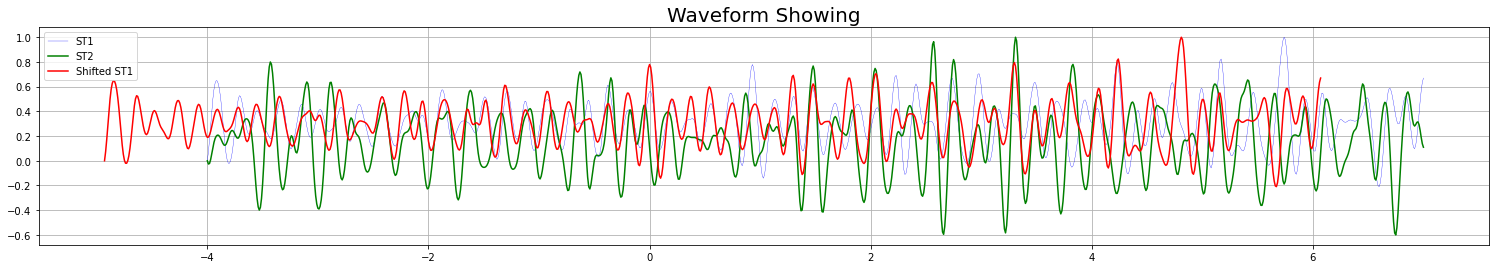

Shift: -0.1100  NCoe: 0.726  evt1: 20200626185507950000  evt2: 20200730134819160000


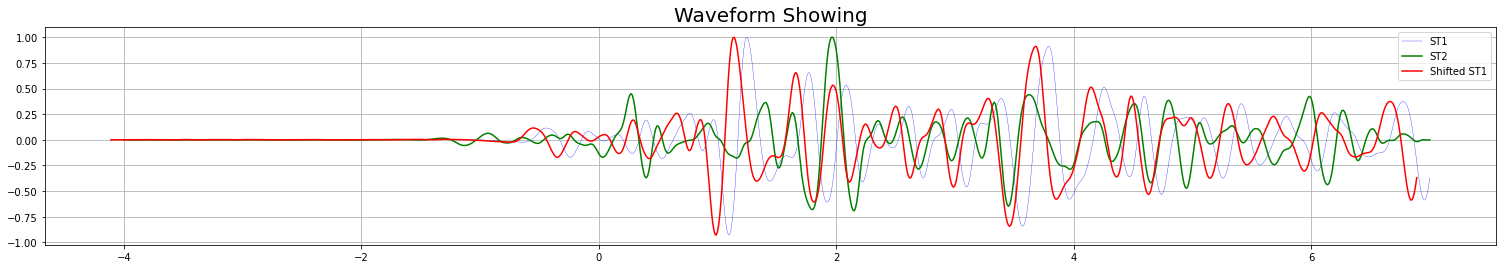

Shift: -0.7200  NCoe: 0.737  evt1: 20200713011828080000  evt2: 20200730112928990000


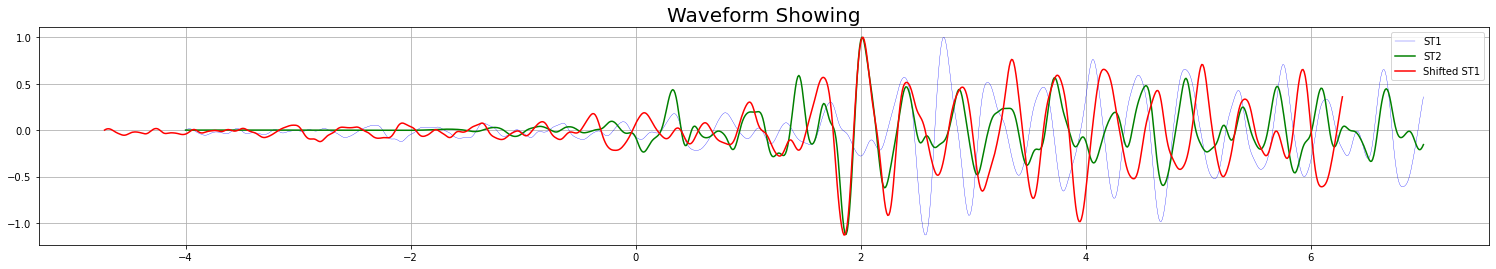

Shift: -0.0600  NCoe: 0.786  evt1: 20200730112928990000  evt2: 20200730134819160000


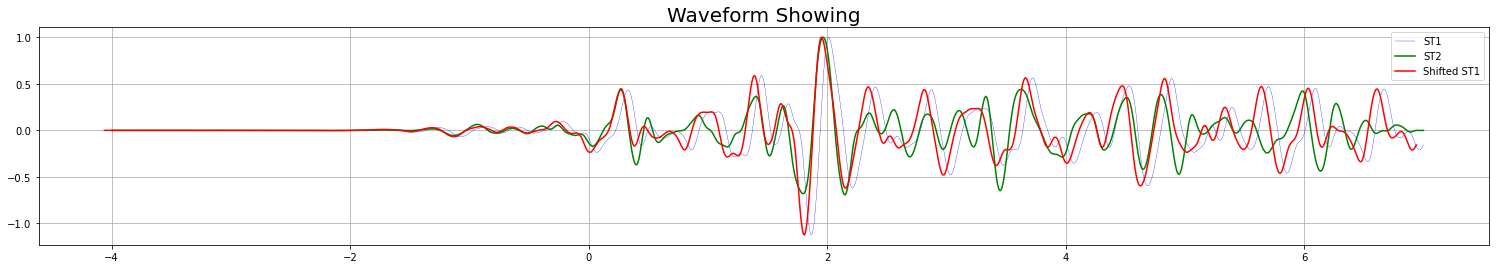

Shift: 0.6200  NCoe: 0.788  evt1: 20200626185507950000  evt2: 20200713011828080000


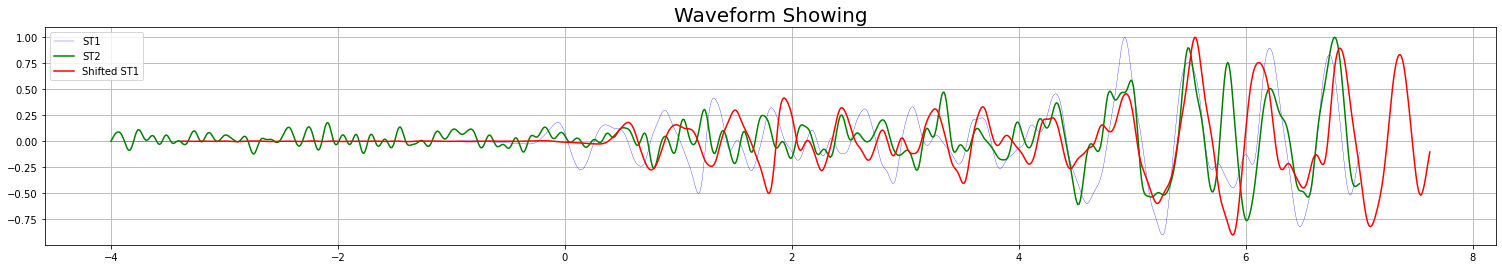

Shift: -0.0700  NCoe: 0.755  evt1: 20200730112928990000  evt2: 20200730134819160000


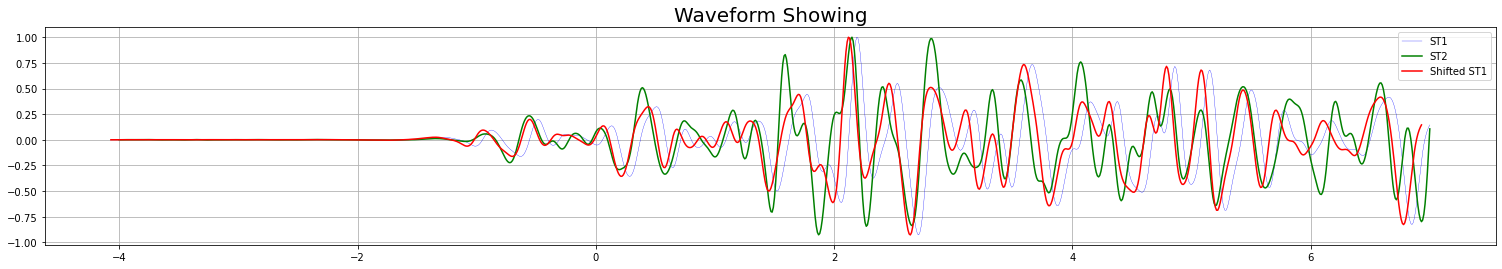

Shift: -0.8700  NCoe: 0.729  evt1: 20200821043305570000  evt2: 20201014214241170000


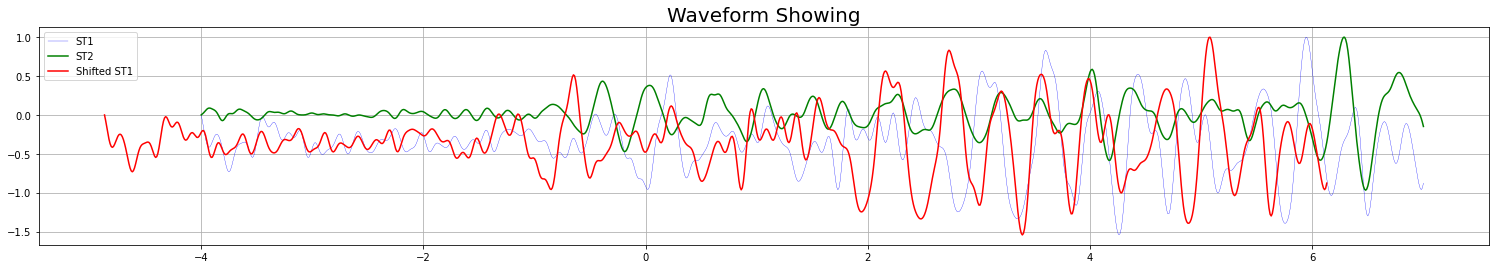

Shift: 0.7700  NCoe: 0.705  evt1: 20200906014836730000  evt2: 20201204031825150000


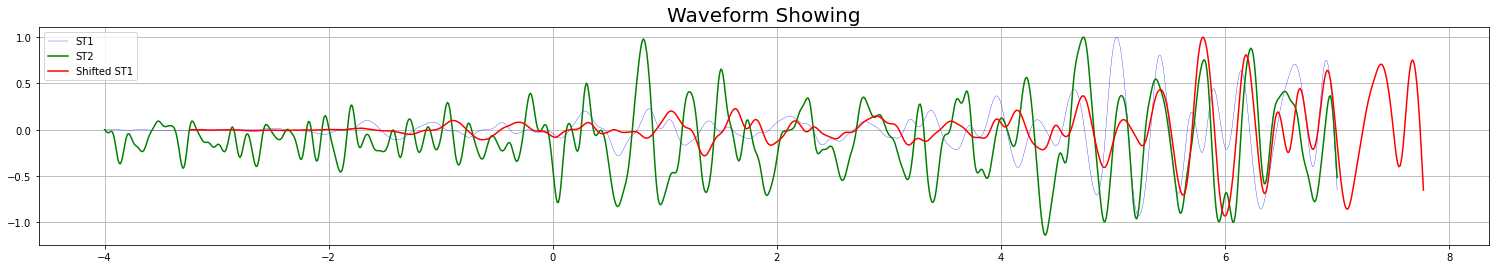

Shift: -0.0400  NCoe: 0.747  evt1: 20200730112928990000  evt2: 20200730134819160000


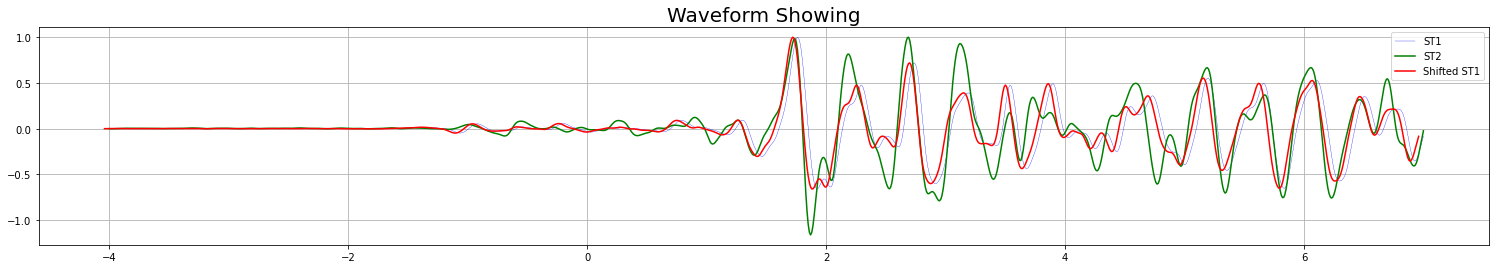

Shift: 0.5200  NCoe: 0.717  evt1: 20200730032301850000  evt2: 20201227190547530000


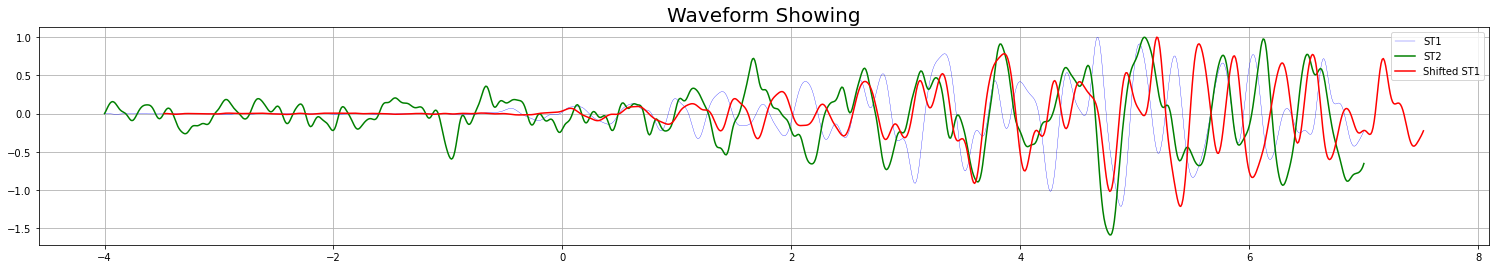

Shift: -0.0500  NCoe: 0.744  evt1: 20200730112928990000  evt2: 20200730134819160000


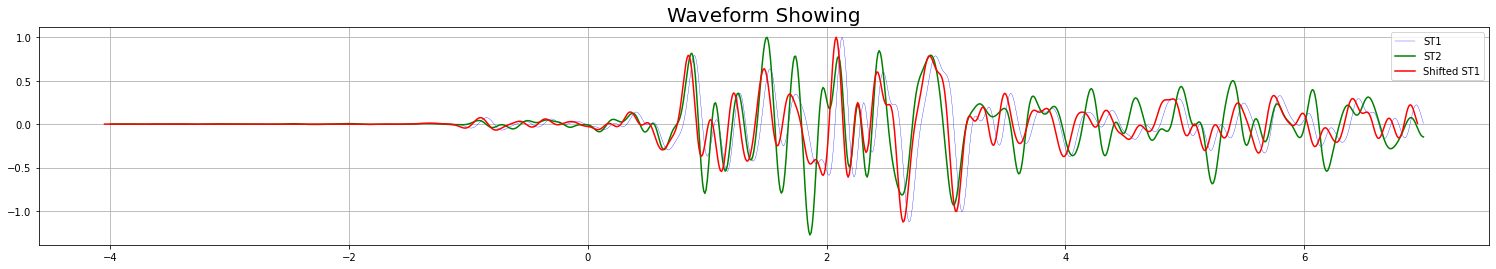

Shift: 0.4900  NCoe: 0.715  evt1: 20200730112928990000  evt2: 20200730134819160000


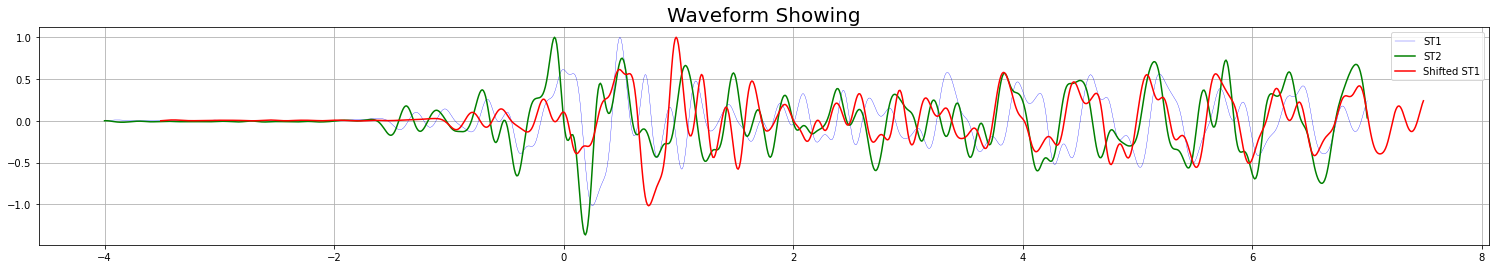

Shift: 0.8000  NCoe: 0.717  evt1: 20200713011828080000  evt2: 20200730134819160000


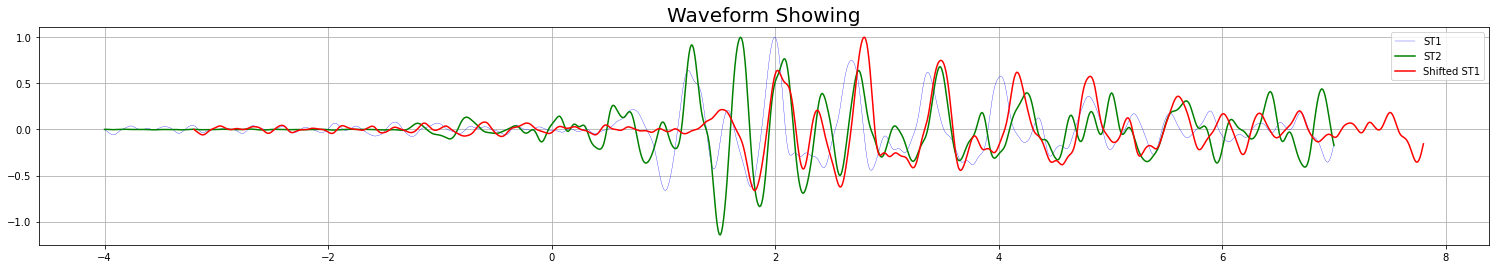

Shift: -0.0500  NCoe: 0.759  evt1: 20200730112928990000  evt2: 20200730134819160000


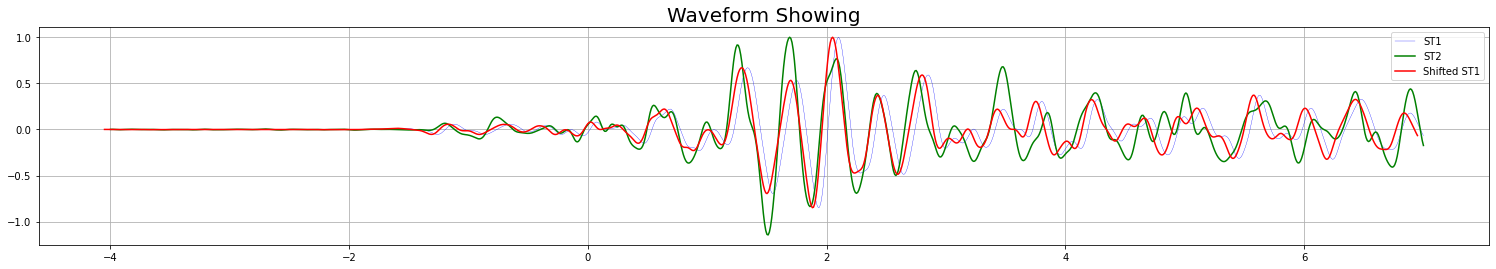

Shift: 0.9400  NCoe: 0.703  evt1: 20200821043305570000  evt2: 20201014214241170000


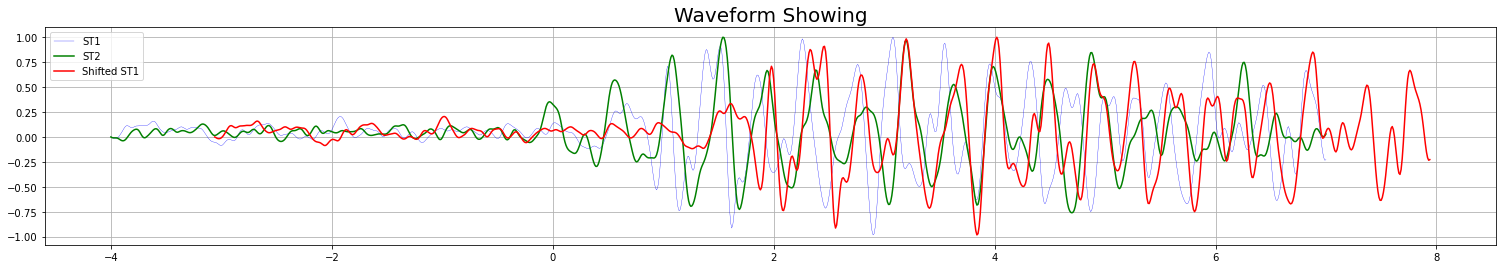

Shift: -0.0400  NCoe: 0.719  evt1: 20200730112928990000  evt2: 20200730134819160000


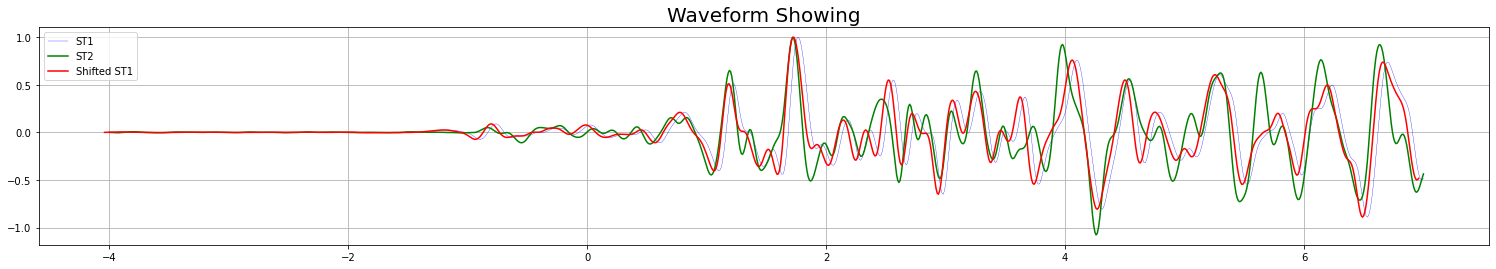

Shift: -0.4200  NCoe: 0.840  evt1: 20200722045709030000  evt2: 20200725023646680000


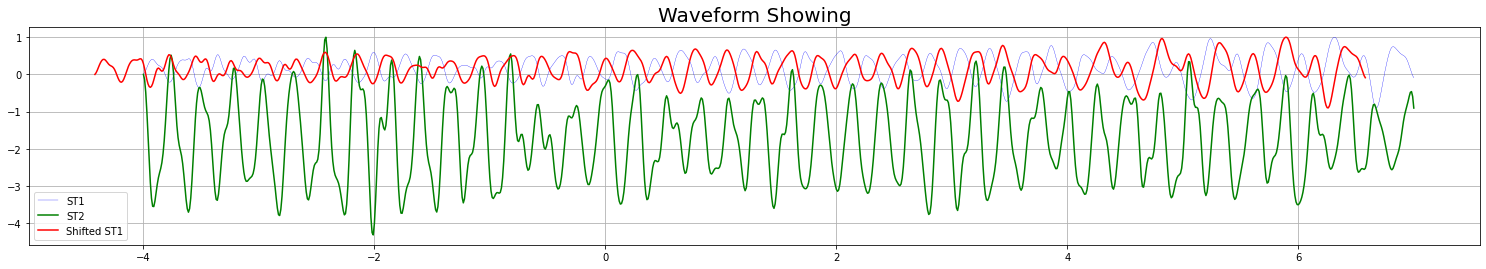

Shift: -0.1700  NCoe: 0.728  evt1: 20200722045709030000  evt2: 20201227190547530000


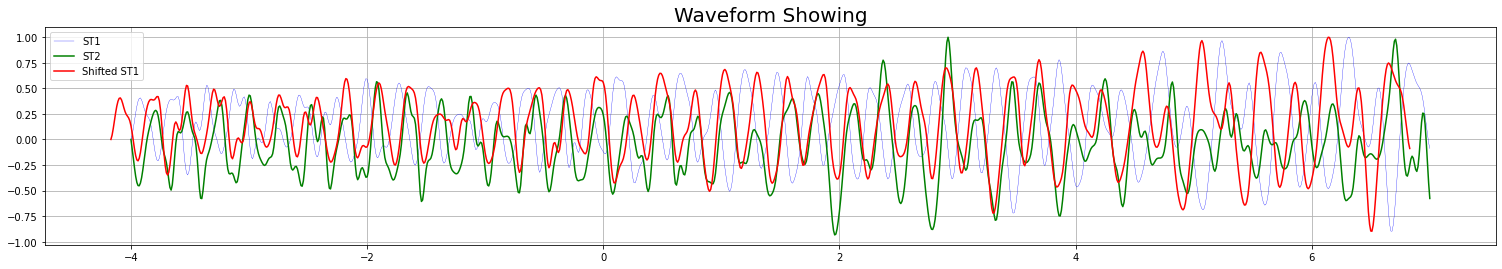

Shift: 0.0000  NCoe: 0.700  evt1: 20200626185507950000  evt2: 20200821043305570000


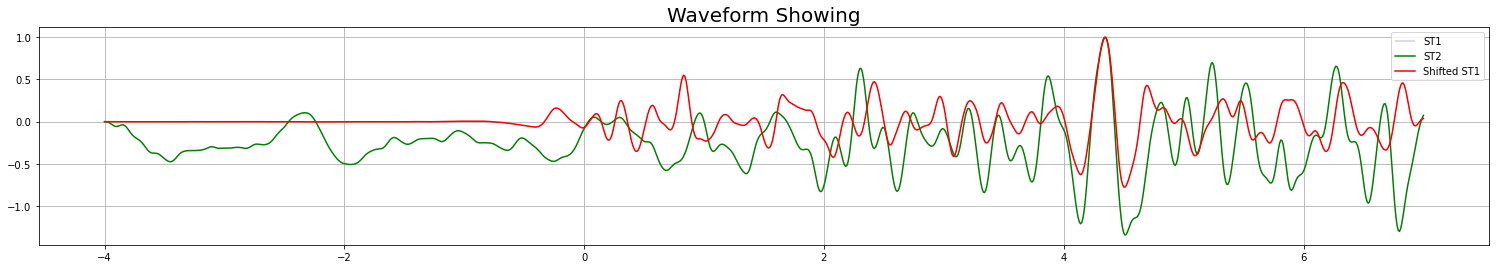

Shift: -0.5100  NCoe: 0.736  evt1: 20200919063846860000  evt2: 20200929022220750000


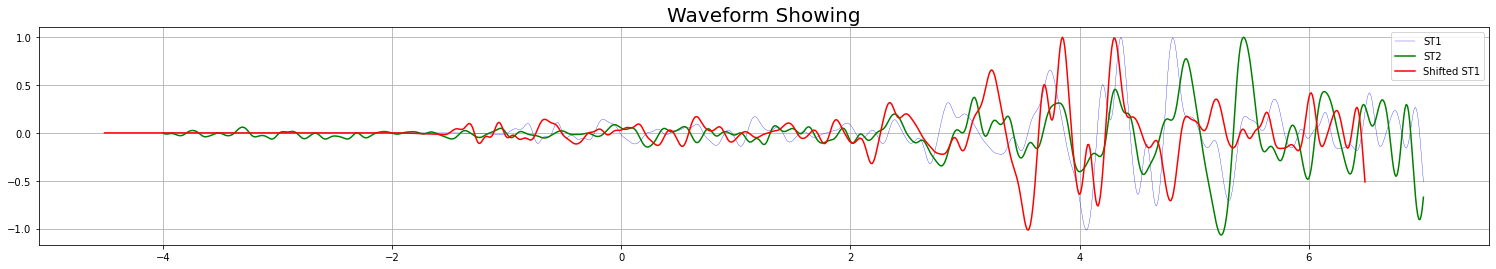

Shift: 0.0000  NCoe: 0.763  evt1: 20200626185507950000  evt2: 20201227190547530000


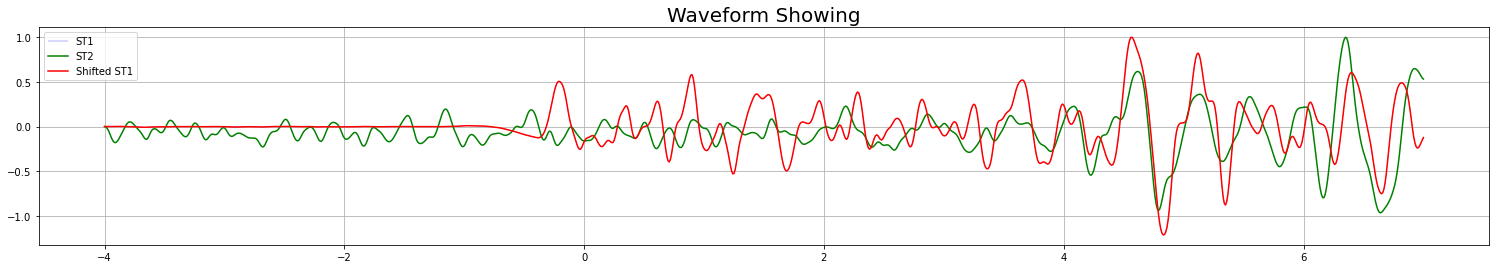

Shift: -0.8000  NCoe: 0.711  evt1: 20200713011828080000  evt2: 20201230083022090000


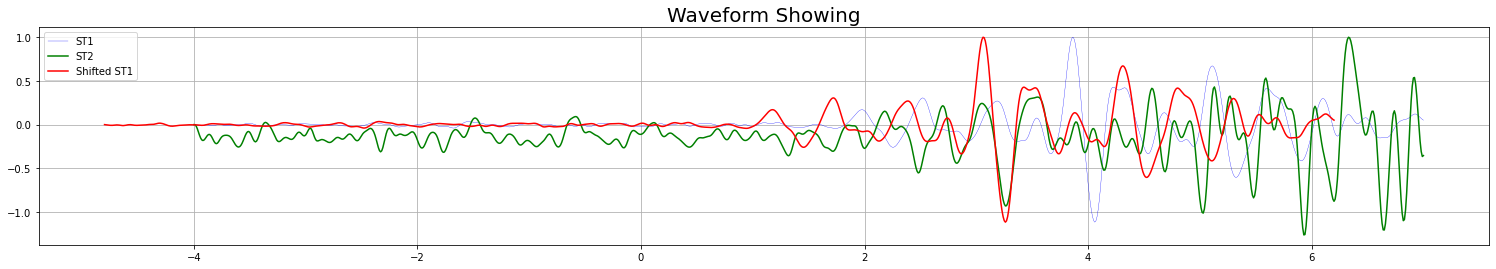

Shift: -0.0500  NCoe: 0.757  evt1: 20200722045709030000  evt2: 20200929022220750000


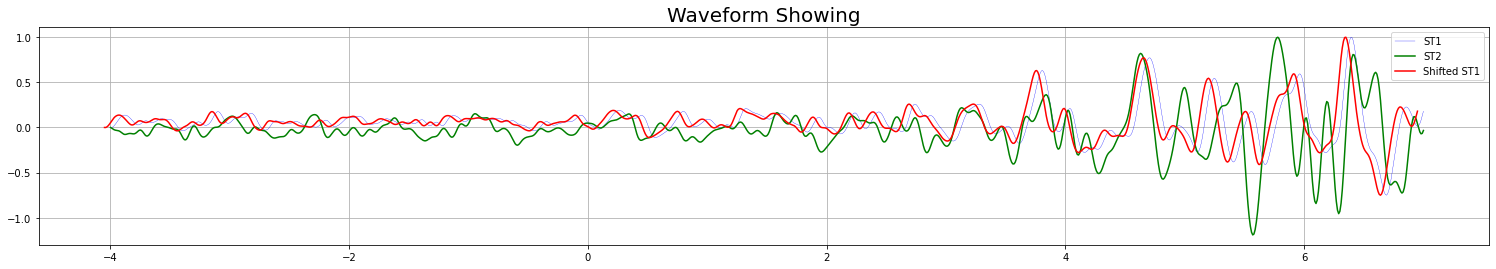

Shift: -0.0500  NCoe: 0.755  evt1: 20200730112928990000  evt2: 20200730134819160000


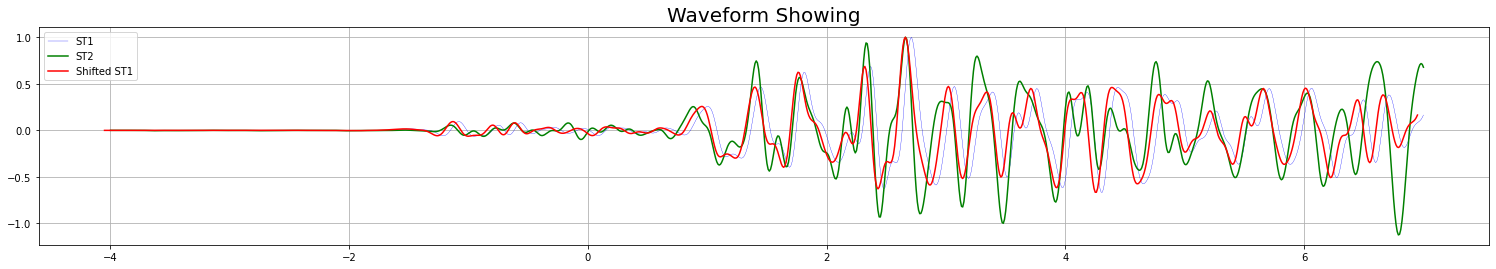

In [114]:
datadir = '/home/tianjue/SPMS/NCA/Data/Download'
data_revgather = f'{datadir}/RVGather'

if not os.path.exists(data_revgather):
        print("Missing File: %s" % data_revgather)

# cut the waveform within the given time window
Tcut1 = 4   # time before P
Tcut2 = 7   # time after P
do_alignP(data_revgather, Tcut1, Tcut2, "SAC")

Tcc1 = 2   # cc window, left before 
Tcc2 = 5   # cc window, right after
Tshift = 1.0   # cc window, possible shift

# measure cc for each two traces within the folder
do_ccmeasure(data_revgather, 0.5, Tcc1, Tcc2, Tshift, "cut")